In [1]:
! pip install git+https://github.com/keras-team/keras-preprocessing.git


  Cloning https://github.com/keras-team/keras-preprocessing.git to c:\users\pc_user\appdata\local\temp\pip-req-build-m8nzy6ak
  Created wheel for Keras-Preprocessing: filename=Keras_Preprocessing-1.1.2-cp36-none-any.whl size=43244 sha256=bf71b5d36a0dc76b1cc3dd2f05f7ce5cf76784c37bd6193993f6ac35d637e29c
  Stored in directory: C:\Users\Pc_User\AppData\Local\Temp\pip-ephem-wheel-cache-p5s6rxhr\wheels\03\a0\39\171f6040d36f36c71168dc69afa81334351b20955dc36ce932
Successfully built Keras-Preprocessing


  Running command git clone -q https://github.com/keras-team/keras-preprocessing.git 'C:\Users\Pc_User\AppData\Local\Temp\pip-req-build-m8nzy6ak'


## For the moment only read a batch of 1000 images

In [13]:
from keras_preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
df = pd.read_csv("C:/Users/Pc_User/Desktop/IBM/train.csv")
df['image_name'] = df['image_name'].apply(lambda x: x + ".jpg")
datagen = ImageDataGenerator()
first_batch = datagen.flow_from_dataframe(dataframe=df, 
                                            directory="C:/Users/Pc_User/Desktop/IBM/train", 
                                            x_col="image_name", y_col="benign_malignant", 
                                            class_mode = 'binary', 
                                            target_size=(256,256), 
                                            batch_size=1000)[0][0]

Found 33126 validated image filenames belonging to 2 classes.


## Create a threshold for images having black corners

In [15]:
im = first_batch.shape[0]

batch = first_batch[list(np.where(np.count_nonzero(first_batch < 50, axis=(1,2,3)) < 1e4)[0]), :, :, :]

discarded_images = im - batch.shape[0]
print(discarded_images)

129


## Average image rectangle

In [16]:
top_height, bottom_height, left_width, right_width = 230, 240, 120, 140

image_rectangles = batch[:, top_height:bottom_height, left_width:right_width, :]

In [17]:
average_image_rectangle = np.sum(image_rectangles, axis=0) / image_rectangles.shape[0]
average_image_rectangle.shape

(10, 20, 3)

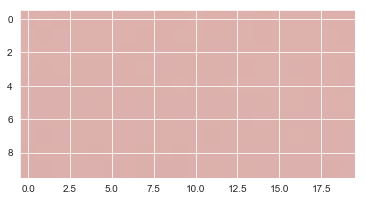

In [18]:
plt.imshow(np.array(average_image_rectangle, dtype = int))

## Grand mean average among channels

In [19]:
average_image_colour = np.sum(image_rectangles, axis=tuple((range(1, image_rectangles.ndim)))) / np.prod(image_rectangles.shape[1:])
average_image_colour

array([172.57167 , 167.39166 , 164.33333 , 192.77333 , 192.55333 ,
       200.22    , 225.945   , 155.02834 , 218.7     , 222.375   ,
       232.51666 , 128.315   , 164.935   , 174.275   , 203.57333 ,
       211.49333 , 200.41167 , 171.13333 , 231.61667 , 169.31334 ,
       209.02333 , 185.22833 , 168.77667 , 162.43167 , 189.92    ,
       165.08333 , 156.98167 , 183.235   , 169.83167 , 202.84666 ,
       184.945   , 212.08667 , 148.34833 , 224.56    , 203.92166 ,
       213.22166 , 214.71834 , 170.40167 , 223.20334 , 238.95833 ,
       215.51666 , 193.475   , 132.36833 , 155.58    , 211.48666 ,
       223.33167 , 204.77167 , 194.50833 , 223.18666 , 233.22333 ,
       232.48833 , 198.75166 , 205.43666 , 146.26167 , 206.40334 ,
       199.23666 , 152.14    , 225.04834 , 216.58667 , 172.755   ,
       203.675   , 177.64667 , 175.765   , 215.555   , 222.91333 ,
       212.39166 , 152.24834 , 222.045   , 213.13167 , 244.23334 ,
       207.83167 , 119.57667 , 202.89833 , 155.66    , 170.186

(array([  2.,   6.,  37.,  66.,  81., 117., 138., 172., 210.,  42.]),
 array([ 78.525   ,  95.543335, 112.56167 , 129.58    , 146.59833 ,
        163.61667 , 180.635   , 197.65334 , 214.67166 , 231.69    ,
        248.70833 ], dtype=float32),
 <a list of 10 Patch objects>)

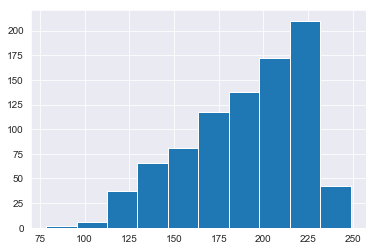

In [20]:
plt.hist(average_image_colour)

## Mean colour for each channel

In [21]:
average_image_rgb = np.sum(image_rectangles, axis=tuple((range(1, image_rectangles.ndim - 1)))) / np.prod(image_rectangles.shape[1:len(image_rectangles.shape) - 1])
average_image_rgb

array([[191.845, 170.945, 154.925],
       [194.55 , 169.955, 137.67 ],
       [181.54 , 161.08 , 150.38 ],
       ...,
       [249.97 , 206.645, 209.43 ],
       [208.53 , 154.   , 170.59 ],
       [253.075, 212.645, 216.995]], dtype=float32)

<BarContainer object of 10 artists>

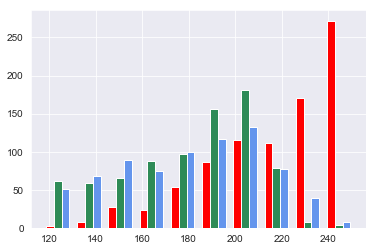

In [27]:
fig, ax = plt.subplots()

r, r_bins = np.histogram(average_image_rgb[:, 0])
g, g_bins = np.histogram(average_image_rgb[:, 1], bins=r_bins)
b, b_bins = np.histogram(average_image_rgb[:, 2], bins=r_bins)

width = (r_bins[1] - r_bins[0])/4

np.arange(average_image_rgb.shape[0]),
ax.bar(x=r_bins[:-1], height=r, width=width, facecolor='r')
ax.bar(x=g_bins[:-1]+width, height=g, width=width, facecolor='seagreen')
ax.bar(x=b_bins[:-1]+width*2, height=b, width=width, facecolor='cornflowerblue')

## Clustering

In [28]:
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D

km = KMeans(n_clusters=2, random_state=0)

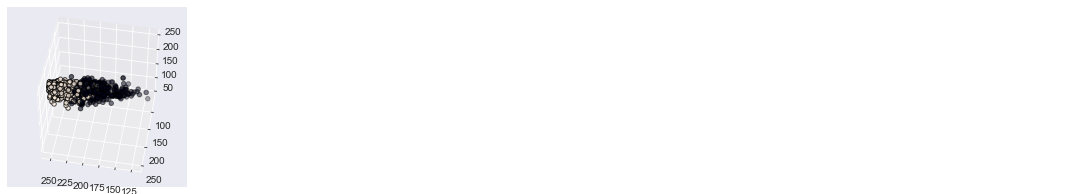

In [29]:
fig = plt.figure(figsize=(10, 10))
ax = Axes3D(fig, rect=[0.15, 0.15, 0.25, 0.25], elev=48, azim=100)

km.fit(average_image_rgb)
labels = km.labels_

ax.scatter(average_image_rgb[:, 0], average_image_rgb[:, 1], average_image_rgb[:, 2], 
           c = labels.astype(np.float), 
           edgecolor='k')